In [ ]:
!pip install ta
!pip install scikeras

# Github com os arquivos
!git clone https://github.com/LuFaiotto/tech-challenge.git

Testando hiperparâmetros: {'batch_size': 32, 'epochs': 100, 'units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.001}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Acurácia média: 0.5057
Testando hiperparâmetros: {'batch_size': 32, 'epochs': 100, 'units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Acurácia média: 0.5108
Testando hiperparâmetros: {'batch_size': 32, 'epochs': 100, 'units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Acurácia média: 0.5036
Testando hiperparâmetros: {'batch_size': 32, 'epochs': 100, 'units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━

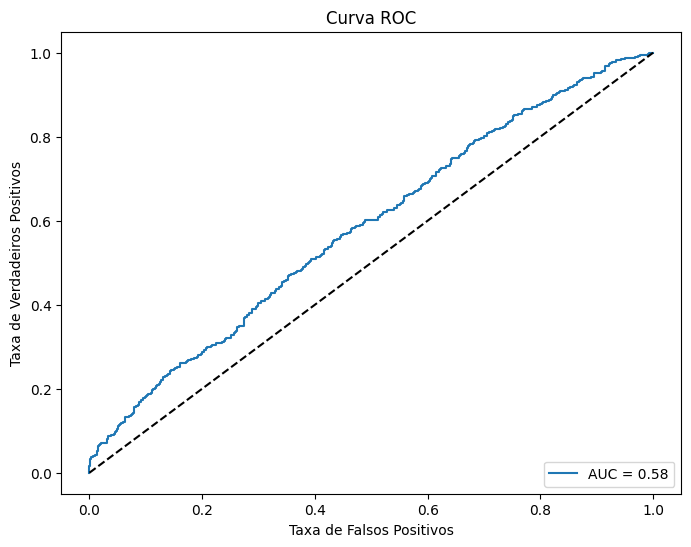

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Acurácia: 0.55
Matriz de Confusão:
 [[11  0]
 [ 9  0]]
Precisão: 0.0
Recall: 0.0
F1 Score: 0.0
Roc Auc Score: 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


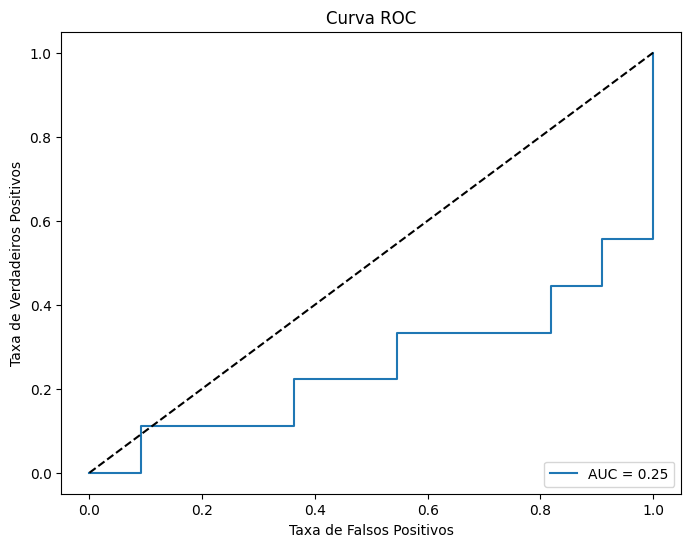

In [2]:
# Modelo LSTM - Imports
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Lendo arquivo do Ibovespa para criação de dataframe
df_1 = pd.read_csv('/content/tech-challenge/Fase_2/Exportacao_Ajustada/Ibovespa_02-01-2020_a_01-07-2025_ajustado.csv', sep=',', engine='python')
df_2 = pd.read_csv('/content/tech-challenge/Fase_2/Exportacao_Ajustada/Ibovespa_02-01-2020_a_30-05-2025_ajustado.csv', sep=',', engine='python')
pd.options.display.float_format = '{:,.4f}'.format

# Convertendo para datetime
df_1['Data'] = pd.to_datetime(df_1['Data'])
df_1.set_index('Data', inplace=True)

# Criando 'Target' com a coluna 'Variação 1/0' da base
df_1['Target'] = df_1['Variacao 1/0']
df_1.dropna(inplace=True)

# Criação de indicadores técnicos, RSI e MACD
df_1['RSI'] = ta.momentum.RSIIndicator(df_1['Último']).rsi()
macd = ta.trend.MACD(df_1['Último'])
df_1['MACD'] = macd.macd()
df_1['MACD_signal'] = macd.macd_signal()

df_1.dropna(inplace=True)

# Dividindo em dados para treino e teste
tamanho = 30
df_treino = df_1[:-tamanho]
df_teste = df_1[-tamanho:]

# Normalização de features
features = ['Último', 'RSI', 'MACD', 'MACD_signal']
scaler = MinMaxScaler()
scaler_treino = scaler.fit_transform(df_treino[features])
scaler_teste = scaler.transform(df_teste[features])

# Criação de sequências para modelo
def criar_sequencia(X, y, passos=1):
    Xs, ys = [], []
    for i in range(len(X) - passos):
        Xs.append(X[i:(i + passos)])
        ys.append(y[i + passos])
    return np.array(Xs), np.array(ys)

passos = 10
X_train, y_train = criar_sequencia(scaler_treino, df_treino['Target'].values, passos)
X_test, y_test = criar_sequencia(scaler_teste, df_teste['Target'].values, passos)

# Criação do modelo LSTM
def criar_modelo_lstm(optimizer='adam', units=50, dropout_rate=0.2, learning_rate=0.00001, input_shape=(passos, len(features))):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Validação Cruzada com TimeSeriesSplit
n_splits = 3
time_series_split = TimeSeriesSplit(n_splits=n_splits)

# Hiperparâmetros
parametros = {
    'batch_size': [32, 64],
    'epochs': [100, 200],
    'units': [50, 100],
    'dropout_rate': [0.1, 0.2],
    'learning_rate': [0.001]
}

# Variáveis para resultados
resultados = []
melhor_modelo = None
melhor_hiperparametro = None
melhor_resultado = float('-inf')

# Combinações de hiperparâmetros
import itertools
keys, values = zip(*parametros.items())
for i in itertools.product(*values):
    hiperparametros = dict(zip(keys, i))
    print(f"Testando hiperparâmetros: {hiperparametros}")

    acuracias_resu = []

    for train_index, val_index in time_series_split.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        teste_hiperparametros = {
            'units': hiperparametros['units'],
            'dropout_rate': hiperparametros['dropout_rate'],
            'learning_rate': hiperparametros['learning_rate'],
            'input_shape': (X_train_fold.shape[1], X_train_fold.shape[2])
        }

        modelo = criar_modelo_lstm(**teste_hiperparametros)
        modelo.fit(X_train_fold, y_train_fold, epochs=hiperparametros['epochs'], batch_size=hiperparametros['batch_size'], verbose=0)

        y_pred_fold = (modelo.predict(X_val_fold) > 0.5).astype(int)
        acuracia = accuracy_score(y_val_fold, y_pred_fold)
        acuracias_resu.append(acuracia)

    # Acurácia média para combinação de hiperparâmetros
    acuracia_media = np.mean(acuracias_resu)
    print(f"Acurácia média: {acuracia_media:.4f}")
    resultados.append((hiperparametros, acuracia_media))

    # Verificando combinação
    if acuracia_media > melhor_resultado:
        melhor_resultado = acuracia_media
        melhor_hiperparametro = hiperparametros
        melhor_modelo = criar_modelo_lstm(**teste_hiperparametros)
        melhor_modelo.fit(X_train, y_train, epochs=hiperparametros['epochs'], batch_size=hiperparametros['batch_size'], verbose=0)  # Treinar o modelo completo

print("Melhor acurácia: %f com %s" % (melhor_resultado, melhor_hiperparametro))

######### TREINAMENTO #########
# Previsão com base de treino
y_pred = (melhor_modelo.predict(X_train) > 0.5).astype(int)

# Métricas da base de treino
print('================================================')
print('================== MODELO LSTM =================')
print('================================================')
print('========== MÉTRICAS - BASE DE TREINO ===========')
print('Acurácia:', accuracy_score(y_train, y_pred))
print('Matriz de Confusão:\n', confusion_matrix(y_train, y_pred))
print('Precisão:', precision_score(y_train, y_pred))
print('Recall:', recall_score(y_train, y_pred))
print('F1 Score:', f1_score(y_train, y_pred))
print('Roc Auc Score:',roc_auc_score(y_train, y_pred))
print('================================================')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, melhor_modelo.predict(X_train))
auc = roc_auc_score(y_train, melhor_modelo.predict(X_train))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - LSTM - Treinamento')
plt.legend(loc='lower right')
plt.show()

######### CONJUNTO DE TESTES #########
# Previsão com base de teste
y_pred = (melhor_modelo.predict(X_test) > 0.5).astype(int)

# Métricas da base de teste
print('================================================')
print('================== MODELO LSTM =================')
print('================================================')
print('=========== MÉTRICAS - BASE DE TESTE ===========')
print('Acurácia:', accuracy_score(y_test, y_pred))
print('Matriz de Confusão:\n', confusion_matrix(y_test, y_pred))
print('Precisão:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Roc Auc Score:',roc_auc_score(y_test, y_pred))
print('================================================')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, melhor_modelo.predict(X_test))
auc = roc_auc_score(y_test, melhor_modelo.predict(X_test))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - LSTM - Conjunto de Testes')
plt.legend(loc='lower right')
plt.show()

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=df7591e1baacf9841563c98520275119f485cb246646345b59b986bae311f165
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
Cloning into 'tech-challenge'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 84 (delta 29), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 317.79 KiB | 5.30 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Testando hiperparâmetros: {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3}
[LightGBM] [Info] Number of positive: 177, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

Acurácia média: 0.7014
[LightGBM] [Info] Number of positive: 673, number of negative: 632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1305, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515709 -> initscore=0.062856
[LightGBM] [Info] Start training from score 0.062856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[LightGBM] [Info] Number of positive: 177, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541284 -> initscore=0.165514
[LightGBM] [Info] Start training from score 0.165514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 504, number of negative: 475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 979, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514811 -> initscore=0.059261
[LightGBM] [Info] Start training from score 0.059261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[LightGBM] [Info] Number of positive: 504, number of negative: 475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 979, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514811 -> initscore=0.059261
[LightGBM] [Info] Start training from score 0.059261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

Testando hiperparâmetros: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 3}
[LightGBM] [Info] Number of positive: 177, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541284 -> initscore=0.165514
[LightGBM] [Info] Start training from score 0.165514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 342, number of negative: 311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 653, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523737 -> initscore=0.095018
[LightGBM] [Info] Start training from score 0.095018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acurácia média: 0.6329
Testando hiperparâmetros: {'n_estimators': 100, 'learning_rate': 0.001, 'max_depth': 7}
[LightGBM] [Info] Number of positive: 177, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541284 -> initscore=0.165514
[LightGBM] [Info] Start training from score 0.165514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acurácia média: 0.6319
Testando hiperparâmetros: {'n_estimators': 100, 'learning_rate': 0.0001, 'max_depth': 3}
[LightGBM] [Info] Number of positive: 177, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541284 -> initscore=0.165514
[LightGBM] [Info] Start training from score 0.165514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acurácia média: 0.5072
Testando hiperparâmetros: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 3}
[LightGBM] [Info] Number of positive: 177, number of negative: 150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541284 -> initscore=0.165514
[LightGBM] [Info] Start training from score 0.165514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 504, number of negative: 475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 979, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514811 -> initscore=0.059261
[LightGBM] [Info] Start training from score 0.059261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 342, number of negative: 311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 653, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523737 -> initscore=0.095018
[LightGBM] [Info] Start training from score 0.095018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 342, number of negative: 311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 653, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523737 -> initscore=0.095018
[LightGBM] [Info] Start training from score 0.095018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 342, number of negative: 311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 653, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523737 -> initscore=0.095018
[LightGBM] [Info] Start training from score 0.095018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acurácia média: 0.7975
Testando hiperparâmetros: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7}
[LightGBM] [Info] Number of positive: 177, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541284 -> initscore=0.165514
[LightGBM] [Info] Start training from score 0.165514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 342, number of negative: 311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 653, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523737 -> initscore=0.095018
[LightGBM] [Info] Start training from score 0.095018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Testando hiperparâmetros: {'n_estimators': 200, 'learning_rate': 0.001, 'max_depth': 3}
[LightGBM] [Info] Number of positive: 177, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541284 -> initscore=0.165514
[LightGBM] [Info] Start training from score 0.165514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 504, number of negative: 475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 979, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514811 -> initscore=0.059261
[LightGBM] [Info] Start training from score 0.059261
Acurácia média: 0.6595
Testando hiperparâmetros: {'n_estimators': 200, 'learning_rate': 0.0001, 'max_depth': 3}
[LightGBM] [Info] Number of positive: 177, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 504, number of negative: 475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 979, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514811 -> initscore=0.059261
[LightGBM] [Info] Start training from score 0.059261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acurácia média: 0.5072
Melhor acurácia: 0.819018 com {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 7}
Acurácia: 1.0
Matriz de Confusão:
 [[632   0]
 [  0 673]]
Precisão: 1.0
Recall: 1.0
F1 Score: 1.0
Roc Auc Score: 1.0


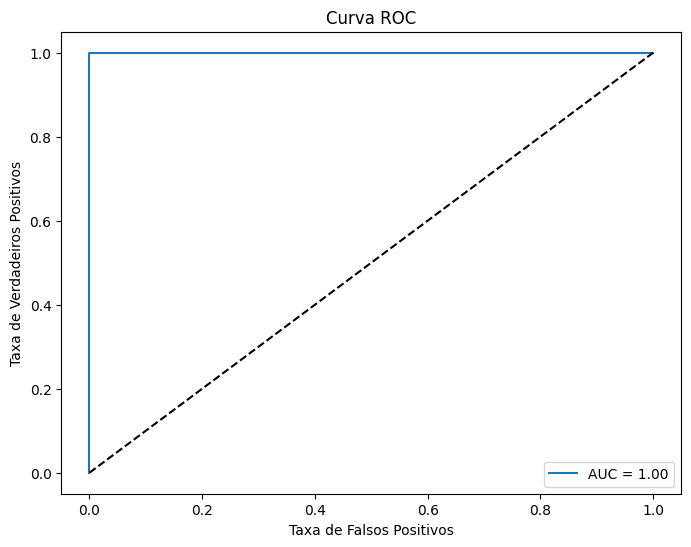

Acurácia: 0.7333333333333333
Matriz de Confusão:
 [[15  2]
 [ 6  7]]
Precisão: 0.7777777777777778
Recall: 0.5384615384615384
F1 Score: 0.6363636363636364
Roc Auc Score: 0.7104072398190044


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


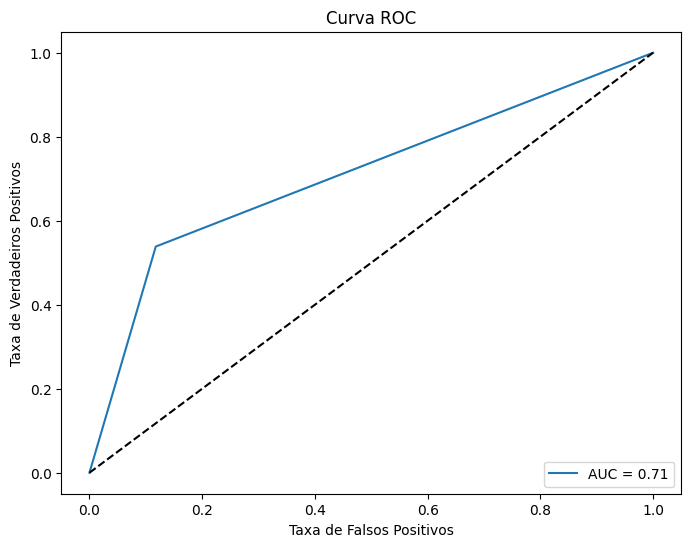

In [1]:
# Modelo LightGBM - Imports
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Lendo arquivo do Ibovespa para criação de dataframe
df_1 = pd.read_csv('/content/tech-challenge/Fase_2/Exportacao_Ajustada/Ibovespa_02-01-2020_a_01-07-2025_ajustado.csv', sep=',', engine='python')
df_2 = pd.read_csv('/content/tech-challenge/Fase_2/Exportacao_Ajustada/Ibovespa_02-01-2020_a_30-05-2025_ajustado.csv', sep=',', engine='python')
pd.options.display.float_format = '{:,.4f}'.format

# Convertendo para datetime
df_1['Data'] = pd.to_datetime(df_1['Data'])
df_1.set_index('Data', inplace=True)

# Criando 'Target' com a coluna 'Variação 1/0' da base
df_1['Target'] = df_1['Variacao 1/0']
df_1.dropna(inplace=True)

# Criação de features com fechamentos dos dias anteriores
for i in range(1, 4):  # D-1, D-2, D-3
    df_1[f'Último_D-{i}'] = df_1['Último'].shift(i)

# Criação de indicadores técnicos, RSI e MACD
df_1['RSI'] = ta.momentum.RSIIndicator(df_1['Último']).rsi()
macd = ta.trend.MACD(df_1['Último'])
df_1['MACD'] = macd.macd()
df_1['MACD_signal'] = macd.macd_signal()

df_1.dropna(inplace=True)

# Dividindo em dados para treino e teste
tamanho = 30
df_treino = df_1[:-tamanho]
df_teste = df_1[-tamanho:]

# Normalização das features
features = ['Último', 'RSI', 'MACD', 'MACD_signal', 'Último_D-1', 'Último_D-2', 'Último_D-3']
scaler = MinMaxScaler()
scaler_treino = scaler.fit_transform(df_treino[features])
scaler_teste = scaler.transform(df_teste[features])

# Variáveis de treino e teste
X_train = scaler_treino
X_test = scaler_teste
y_train = df_treino['Target'].values
y_test = df_teste['Target'].values

# Criação do modelo LightGBM
def criar_modelo_lgbm(n_estimators=100, learning_rate=0.001, max_depth=5):
    model = lgb.LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42)
    return model

# Validação Cruzada com TimeSeriesSplit
n_splits = 3
time_series_split = TimeSeriesSplit(n_splits=n_splits)

# Hiperparâmetros
parametros = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.001, 0.0001],
    'max_depth': [3, 5, 7]
}

# Variáveis para resultados
resultados = []
melhor_modelo = None
melhor_hiperparametro = None
melhor_resultado = float('-inf')

# Combinações de hiperparâmetros
import itertools
keys, values = zip(*parametros.items())
for i in itertools.product(*values):
    hiperparametros = dict(zip(keys, i))
    print(f"Testando hiperparâmetros: {hiperparametros}")

    acuracias_resu = []

    for train_index, val_index in time_series_split.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = criar_modelo_lgbm(**hiperparametros)
        model.fit(X_train_fold, y_train_fold)

        y_pred_fold = model.predict(X_val_fold)
        acuracia = accuracy_score(y_val_fold, y_pred_fold)
        acuracias_resu.append(acuracia)

    # Acurácia média para combinação de hiperparâmetros
    acuracia_media = np.mean(acuracias_resu)
    print(f"Acurácia média: {acuracia_media:.4f}")
    resultados.append((hiperparametros, acuracia_media))

    # Verificando combinação
    if acuracia_media > melhor_resultado:
        melhor_resultado = acuracia_media
        melhor_hiperparametro = hiperparametros
        melhor_modelo = criar_modelo_lgbm(**hiperparametros)  # Criar um novo modelo com os melhores hiperparâmetros
        melhor_modelo.fit(X_train, y_train)  # Treinar o modelo completo

print("Melhor acurácia: %f com %s" % (melhor_resultado, melhor_hiperparametro))

######### TREINAMENTO #########
# Previsão com base de treino
y_pred = melhor_modelo.predict(X_train)

# Métricas da base de treino
print('================================================')
print('================== MODELO LGBM =================')
print('================================================')
print('========== MÉTRICAS - BASE DE TREINO ===========')
print('Acurácia:', accuracy_score(y_train, y_pred))
print('Matriz de Confusão:\n', confusion_matrix(y_train, y_pred))
print('Precisão:', precision_score(y_train, y_pred))
print('Recall:', recall_score(y_train, y_pred))
print('F1 Score:', f1_score(y_train, y_pred))
print('Roc Auc Score:',roc_auc_score(y_train, y_pred))
print('================================================')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, melhor_modelo.predict(X_train))
auc = roc_auc_score(y_train, melhor_modelo.predict(X_train))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - LightGBM - Treinamento')
plt.legend(loc='lower right')
plt.show()

######### CONJUNTO DE TESTES #########
# Previsão com base de teste
y_pred = melhor_modelo.predict(X_test)

# Métricas da base de teste
print('================================================')
print('================== MODELO LGBM =================')
print('================================================')
print('=========== MÉTRICAS - BASE DE TESTE ===========')
print('Acurácia:', accuracy_score(y_test, y_pred))
print('Matriz de Confusão:\n', confusion_matrix(y_test, y_pred))
print('Precisão:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Roc Auc Score:',roc_auc_score(y_test, y_pred))
print('================================================')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, melhor_modelo.predict(X_test))
auc = roc_auc_score(y_test, melhor_modelo.predict(X_test))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - LightGBM - Conjunto de Testes')
plt.legend(loc='lower right')
plt.show()